In [1]:
import torch
from torch.utils.data import Dataset, DataLoader 
import torch.nn as nn
from torchinfo import summary 
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import os
import numpy as np
import string

In [2]:
# Utilisation du GPU si disponible
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Dataset personnalisé avec les outputs de l'avant dernière couche du RESNET50 pour les images du dataset de train ImageNet
class PenultimateOutputsDataset(Dataset):
    def __init__(self, folder_path, device='cpu'):
        with open(f'{folder_path}/penultimate_layer_outputs/data.json') as data:
            self.data_tensors = json.load(data)
        self.file_list = [f'{folder_path}/penultimate_layer_outputs/penultimate_layer_outputs_{index}.pt' for index in range(self.data_tensors['last_file_indice']+1)]
        self.labels = torch.load(f'{folder_path}/penultimate_layer_labels.pt', map_location=device).long()
        self.length = self.data_tensors['min_size_segmentation']*self.data_tensors['last_file_indice']+torch.load(f'{folder_path}/penultimate_layer_outputs/penultimate_layer_outputs_{self.data_tensors["last_file_indice"]}.pt', map_location=device).shape[0]
        self.device = device
        self.data_cache = None
        
    def __len__(self):
        return self.length

    def __getitem__(self, index):
        if index < 0 or index >= self.length :
           raise ValueError(f'Index need to be between 0 and {self.length-1}')
        index_file = index//self.data_tensors['min_size_segmentation']
        index_in_file = index%self.data_tensors['min_size_segmentation']
        if (self.data_cache is None) or self.data_cache[0] != index_file :
            file = self.file_list[index_file]
            tensors = torch.load(file, map_location=self.device)
            self.data_cache = (index_file, tensors)
        tensor = self.data_cache[1][index_in_file]
        label = self.labels[index]
        return tensor, label


In [4]:
# Définition des constantes et des hyper-paramètres

outputs_folder = "../data/saved_outputs/val"
models_folder = "../data/saved_models/various_weight_decay_models"
if not os.path.exists(models_folder):
    os.makedirs(models_folder)
    
input_size = 2048
num_classes = 1000

batch_size = 2000
num_epochs = 90

num_weight_decay = 9
weight_decay_parameters = torch.cat((torch.tensor([0e0,1e-7]), torch.logspace(-6,-2, num_weight_decay)), dim=0)
learning_rate = 0.1
momentum = 0.9
lr_decay_step = 30
decay_rate = 0.1


In [5]:
# Instanciation du dataset et du dataloader
dataset = PenultimateOutputsDataset(outputs_folder)
train_loader = DataLoader(dataset, batch_size=batch_size, pin_memory=True)
len(dataset)

50000

In [6]:
torch.manual_seed(0) # Reproductibilité de l'expérience

# Définition du modèle de régression logistique avec torch 
class LogisticRegression(nn.Module): 
    def __init__(self, input_size, num_classes): 
        super(LogisticRegression, self).__init__() 
        self.linear = nn.Linear(input_size, num_classes) 
  
    def forward(self, x): 
        out = self.linear(x) 
        return out
        
    def load_weights(self, weights) :
        self.load_state_dict(weights)

In [7]:
# Entraînement des modèles
last_outputs = torch.tensor([]).to(DEVICE)
for training_index, weight_decay_parameter in enumerate(weight_decay_parameters) :

    print(f"Processing step {training_index+1}/{len(weight_decay_parameters)}, weight decay = {weight_decay_parameter:.3e}.")
    
    # On définit le modèle
    model = LogisticRegression(input_size=input_size, num_classes=num_classes)
    model = model.to(DEVICE)

    # Définition de la fonction de loss et de l'optimiseur
    loss_function = nn.CrossEntropyLoss() 

    # Définition du répertoire associé
    folder_path = os.path.join(models_folder, f"{training_index+1 if (training_index+1) <=9 else list(string.ascii_lowercase)[(training_index+1)%10]}_weight_decay_{weight_decay_parameter:.3e}")
    
    # Initialisation des différentes variables pour stocker les éléments intéressants
    accuracy_history = []
    loss_history = torch.tensor([]).to(DEVICE) 
    complete_optimized_function_value_history = torch.tensor([]).to(DEVICE) 
    mean_loss_class = torch.tensor([]).to(DEVICE)
    mean_loss_class2 = torch.tensor([]).to(DEVICE)
    weights_epoch = torch.tensor([]).to(DEVICE) 
    # Obtention du nombre d'images par classe
    nb_image_class = torch.bincount(dataset.labels).to(DEVICE)
    
    for epoch in range(num_epochs-1,num_epochs): 
        # if epoch == num_epochs-1:
        #     intermediate_outputs = torch.tensor([])
        # Définition des répertoires associés
        models_path = os.path.join(folder_path, "models")
        data_path = os.path.join(folder_path, "train")
        if not os.path.exists(data_path):
            os.makedirs(data_path)
            
        model.load_weights(torch.load(f'{models_path}/epoch-{epoch}.pt', map_location=DEVICE))
        # Initialisation du nombre de prédictions correctes
        correct_predictions = 0
    
        # Initialisation du vecteur de la somme des erreurs pour chaque classe
        class_loss = torch.zeros(1000, device=DEVICE)
        class_loss2 = torch.zeros(1000, device=DEVICE)
        
        model.eval()
        with torch.no_grad():
        
            for inputs, labels in tqdm(train_loader):
                
                # Chargement dans le bon appareil
                inputs = inputs.to(DEVICE) 
                labels = labels.to(DEVICE)
                # Forward pass 
                outputs = model(inputs) 
                loss = loss_function(outputs, labels)
                complete_optimized_function_value = loss + weight_decay_parameter * sum(t.pow(2).sum() for t in model.state_dict().values()) / 2
        
                # Calcul des erreurs pour chaque image et ajout dans class_loss
                input_loss2 = nn.functional.cross_entropy(outputs,labels,reduction='none') #+ weight_decay_parameter * sum(t.pow(2).sum() for t in model.state_dict().values()) / 2
                input_loss = nn.functional.cross_entropy(outputs,labels,reduction='none') + weight_decay_parameter * sum(t.pow(2).sum() for t in model.state_dict().values()) / 2
                class_loss2.index_add_(0,labels,input_loss2)
                class_loss.index_add_(0,labels,input_loss)
                
                # Ajout des prédictions correctes au total
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()
                
                # if epoch == num_epochs-1:
                #     intermediate_outputs = torch.cat((intermediate_outputs, outputs.cpu()), dim=0)
    
        # Calcul de la précision
        accuracy = 100 * correct_predictions / len(dataset)
    
        # Sauvegarde des différentes mesures
        accuracy_history.append(accuracy)
        loss_history = torch.cat((loss_history, loss.unsqueeze(0)), dim=0)
        complete_optimized_function_value_history = torch.cat((complete_optimized_function_value_history, complete_optimized_function_value.unsqueeze(0)), dim=0)
        mean_loss_class = torch.cat((mean_loss_class, (class_loss/nb_image_class).detach().unsqueeze(0)), dim=0)
        mean_loss_class2 = torch.cat((mean_loss_class2, (class_loss2/nb_image_class).detach().unsqueeze(0)), dim=0)
        weights_epoch = torch.cat((weights_epoch, sum(t.abs().sum() for t in model.state_dict().values()).unsqueeze(0)), dim=0)
        # Affichage
        print(f'>> Epoch [{epoch+1}/{num_epochs}] : Accuracy: {accuracy} -- Complete optimized function value: {complete_optimized_function_value.item()}')
            
    # Sauvegarde de toutes les données importantes liées à l'entraînement du modèle
    torch.save(accuracy_history, f'{data_path}/accuracy.pt')
    torch.save(loss_history, f'{data_path}/loss.pt')
    torch.save(complete_optimized_function_value_history, f'{data_path}/complete_optimized_function_values.pt')
    torch.save(mean_loss_class, f'{data_path}/mean_loss_class.pt')
    torch.save(mean_loss_class2, f'{data_path}/mean_loss_class2.pt')
    torch.save(weights_epoch, f'{data_path}/weights.pt')
    # last_outputs = torch.cat((last_outputs, intermediate_outputs.unsqueeze(0)), dim=0)


    

    print(f"Step {training_index+1}/{len(weight_decay_parameters)} completed.")

last_outputs_path=os.path.join(models_folder,"last_outputs_per_wd","train")
if not os.path.exists(last_outputs_path):
    os.makedirs(last_outputs_path)
# torch.save(last_outputs, f'{last_outputs_path}/last_ouputs_per_wd.pt')

Processing step 1/11, weight decay = 0.000e+00.


100%|████████████████████████████████████████████████████████████████████████████████| 641/641 [00:37<00:00, 17.14it/s]


>> Epoch [90/90] : Accuracy: 92.5341505049693 -- Complete optimized function value: 2.0490076541900635
Step 1/11 completed.
Processing step 2/11, weight decay = 1.000e-07.


100%|████████████████████████████████████████████████████████████████████████████████| 641/641 [00:44<00:00, 14.38it/s]


>> Epoch [90/90] : Accuracy: 92.52946727475809 -- Complete optimized function value: 2.0778276920318604
Step 2/11 completed.
Processing step 3/11, weight decay = 1.000e-06.


100%|████████████████████████████████████████████████████████████████████████████████| 641/641 [00:44<00:00, 14.31it/s]


>> Epoch [90/90] : Accuracy: 92.49262586376327 -- Complete optimized function value: 2.260209083557129
Step 3/11 completed.
Processing step 4/11, weight decay = 3.162e-06.


100%|████████████████████████████████████████████████████████████████████████████████| 641/641 [00:44<00:00, 14.28it/s]


>> Epoch [90/90] : Accuracy: 92.37015939374024 -- Complete optimized function value: 2.4890098571777344
Step 4/11 completed.
Processing step 5/11, weight decay = 1.000e-05.


100%|████████████████████████████████████████████████████████████████████████████████| 641/641 [00:45<00:00, 14.24it/s]


>> Epoch [90/90] : Accuracy: 91.9165104939481 -- Complete optimized function value: 2.6311097145080566
Step 5/11 completed.
Processing step 6/11, weight decay = 3.162e-05.


100%|████████████████████████████████████████████████████████████████████████████████| 641/641 [00:45<00:00, 14.02it/s]


>> Epoch [90/90] : Accuracy: 91.4433481349426 -- Complete optimized function value: 1.8590087890625
Step 6/11 completed.
Processing step 7/11, weight decay = 1.000e-04.


100%|████████████████████████████████████████████████████████████████████████████████| 641/641 [00:45<00:00, 14.02it/s]


>> Epoch [90/90] : Accuracy: 91.50313737397232 -- Complete optimized function value: 0.8203436136245728
Step 7/11 completed.
Processing step 8/11, weight decay = 3.162e-04.


100%|████████████████████████████████████████████████████████████████████████████████| 641/641 [00:48<00:00, 13.16it/s]


>> Epoch [90/90] : Accuracy: 90.11346686263383 -- Complete optimized function value: 1.196799397468567
Step 8/11 completed.
Processing step 9/11, weight decay = 1.000e-03.


100%|████████████████████████████████████████████████████████████████████████████████| 641/641 [00:46<00:00, 13.82it/s]


>> Epoch [90/90] : Accuracy: 88.34726464231439 -- Complete optimized function value: 2.1187047958374023
Step 9/11 completed.
Processing step 10/11, weight decay = 3.162e-03.


100%|████████████████████████████████████████████████████████████████████████████████| 641/641 [00:48<00:00, 13.30it/s]


>> Epoch [90/90] : Accuracy: 85.75252094379577 -- Complete optimized function value: 3.9634876251220703
Step 10/11 completed.
Processing step 11/11, weight decay = 1.000e-02.


100%|████████████████████████████████████████████████████████████████████████████████| 641/641 [00:48<00:00, 13.28it/s]

>> Epoch [90/90] : Accuracy: 79.45638624785059 -- Complete optimized function value: 6.113310813903809
Step 11/11 completed.


In [7]:
def get_subdirectories(directory):
    return [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    
def get_data_directories(models_folder, directories, data_name):
    directories = [os.path.join(models_folder, d, "test_new_mean_loss_class" ,data_name) for d in directories]
    return [(torch.load(i, map_location='cpu') if isinstance(torch.load(i, map_location='cpu'), list) else torch.load(i, map_location='cpu').detach()) for i in directories]

def plot_data_per_wd(data_names, data, name):
    plt.figure()
    for index, tensor in enumerate(data) :
        plt.plot(tensor, label=data_names[index][2:])
    plt.title(name)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.savefig(os.path.join("..","figures",f"{name}.svg"))
    plt.show()

In [8]:
subdirectories = get_subdirectories(models_folder)
subdirectories = subdirectories[:-1]
accuracy = get_data_directories(models_folder, subdirectories, "accuracy.pt")
complete_optimized_function_values = get_data_directories(models_folder, subdirectories, "complete_optimized_function_values.pt")
loss = get_data_directories(models_folder, subdirectories, "loss.pt")
mean_loss_class = get_data_directories(models_folder, subdirectories, "mean_loss_class2.pt")
weights = get_data_directories(models_folder, subdirectories, "weights.pt")

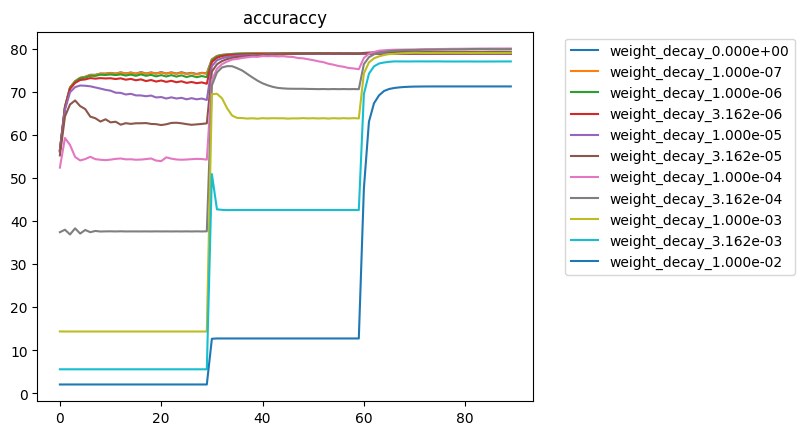

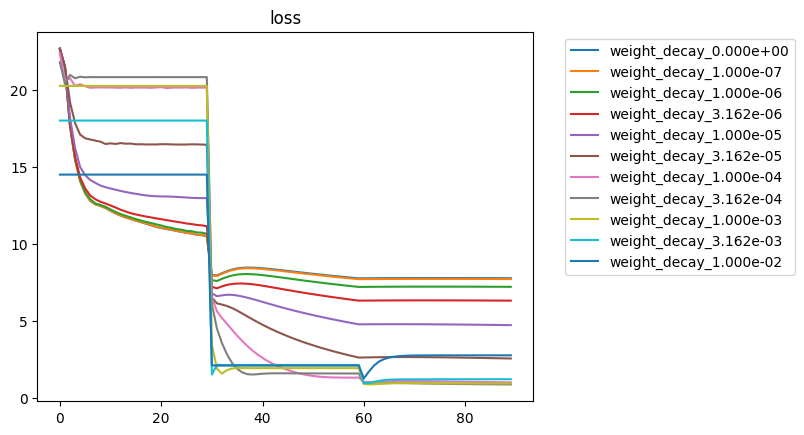

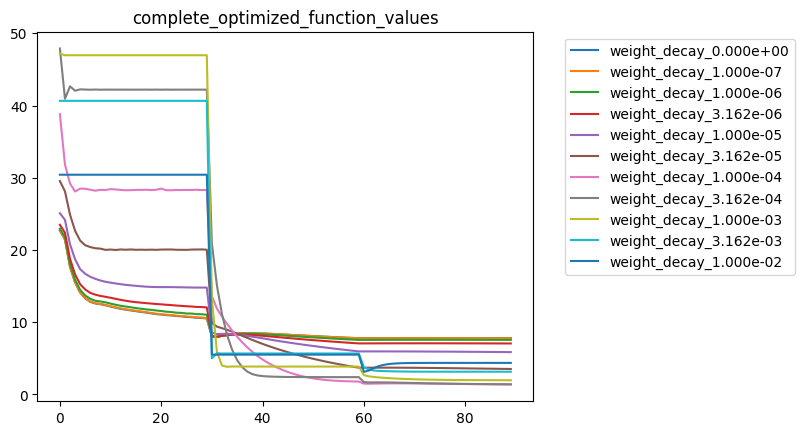

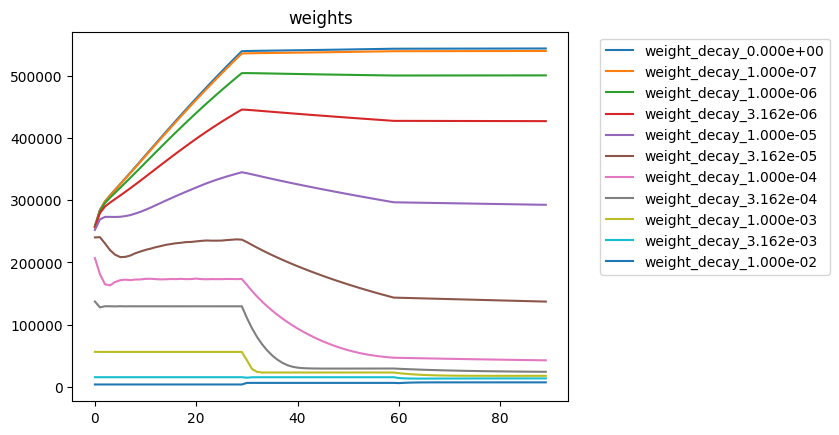

In [76]:
plot_data_per_wd(subdirectories, accuracy, "accuraccy")
plot_data_per_wd(subdirectories, loss, "loss")
plot_data_per_wd(subdirectories, complete_optimized_function_values, "complete_optimized_function_values")
plot_data_per_wd(subdirectories, weights, "weights")


In [77]:
inte = torch.tensor([])
for i in mean_loss_class:
    inte = torch.cat((inte, i[89,:].unsqueeze(0)),dim=0)

In [78]:
torch.argmin(inte, dim=0).float().dtype

torch.float32

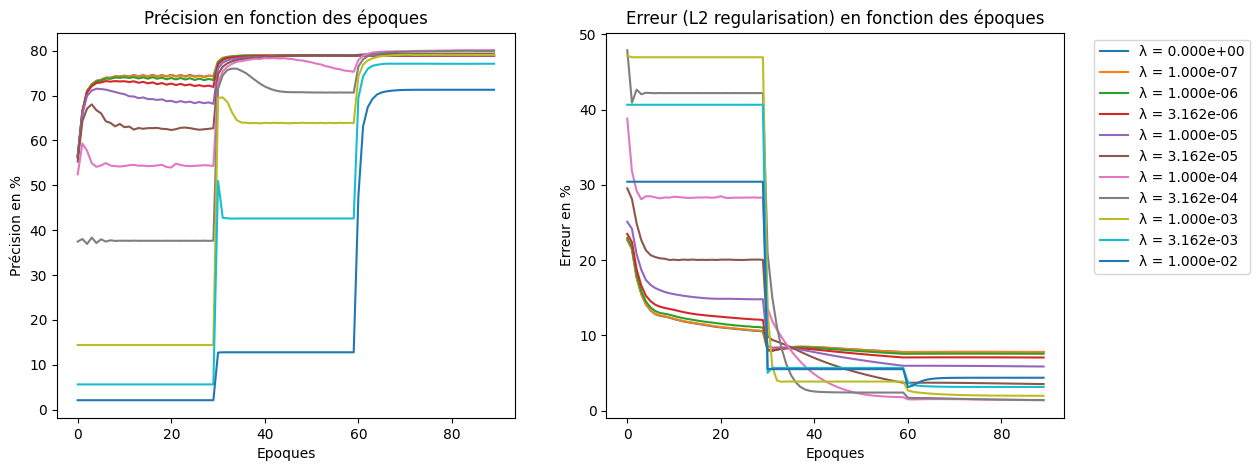

In [36]:
data_names = subdirectories
fig, axes = plt.subplots(1, 2,figsize=(13, 5))  


for index, tensor in enumerate(accuracy) :
    axes[0].plot(tensor, label=f"λ = {data_names[index][-9:]}")
axes[0].set_xlabel("Epoques")
axes[0].set_ylabel("Précision en %")
#axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].set_title("Précision en fonction des époques")

for index, tensor in enumerate(complete_optimized_function_values) :
    axes[1].plot(tensor, label=f"λ = {data_names[index][-9:]}")
axes[1].set_xlabel("Epoques")
axes[1].set_ylabel("Erreur en %")
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].set_title("Erreur (L2 regularisation) en fonction des époques")
plt.savefig('../figures/Erreur et Precision en fonction de epoque selon wd.svg')
plt.show()



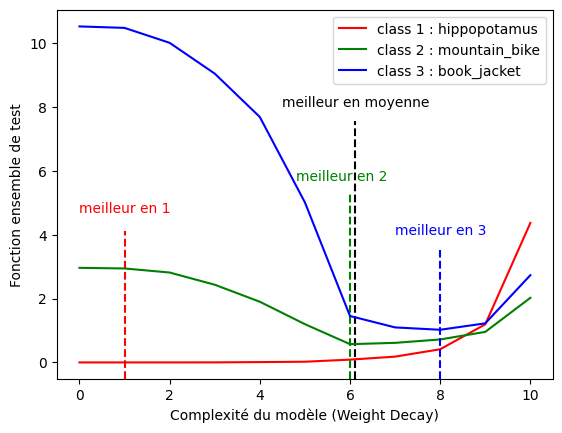

In [67]:
plt.figure()
plt.axvline(x=torch.mean(torch.argmin(inte, dim=0).float()), ymax=0.7, color='black', linestyle='--')
plt.text(4.5, 8, "meilleur en moyenne", color='black')
plt.plot(inte[:,344],label = "class 1 : hippopotamus",color='r')
plt.axvline(x=torch.argmin(inte[:,344]), ymax=0.4, color='r', linestyle='--')
plt.text(0, 4.7, "meilleur en 1", color='r')
plt.plot(inte[:,671],label = "class 2 : mountain_bike",color='g')
plt.axvline(x=torch.argmin(inte[:,671]), ymax=0.5, color='g', linestyle='--')
plt.text(4.8, 5.7, "meilleur en 2", color='g')
plt.plot(inte[:,921],label = "class 3 : book_jacket", color='b')
plt.axvline(x=torch.argmin(inte[:,921]), ymax=0.35, color='b', linestyle='--')
plt.text(7, 4, "meilleur en 3", color='b')
plt.ylabel("Fonction ensemble de test")
plt.xlabel("Complexité du modèle (Weight Decay)")
plt.legend()
plt.savefig("../figures/class_inequalities.svg")
plt.show()

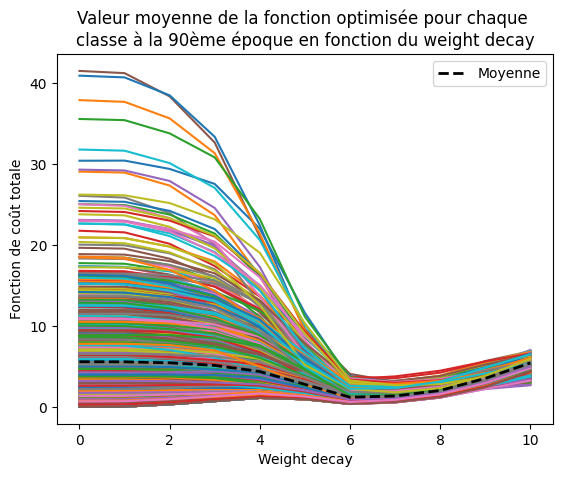

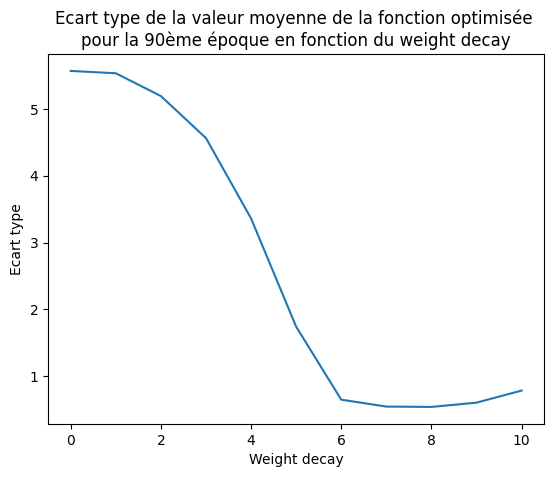

In [12]:
plt.figure()
for i in range(1000):
    plt.plot(inte[:,i])
plt.plot(inte.mean(dim=1), color = 'black', linewidth ="2", linestyle="--", label = "Moyenne")
plt.title("Valeur moyenne de la fonction optimisée pour chaque \nclasse à la 90ème époque en fonction du weight decay")
plt.ylabel("Fonction de coût totale")
plt.xlabel("Weight decay")
plt.legend()
plt.show()

plt.figure()
plt.title("Ecart type de la valeur moyenne de la fonction optimisée \npour la 90ème époque en fonction du weight decay")
plt.ylabel("Ecart type")
plt.xlabel("Weight decay")
plt.plot(inte.std(dim=1))
plt.show()

In [16]:
inte.mean(dim=0).shape

torch.Size([1000])

[ 20.   6.   1.   7.  12.  68. 541. 305.  39.   1.   0.]


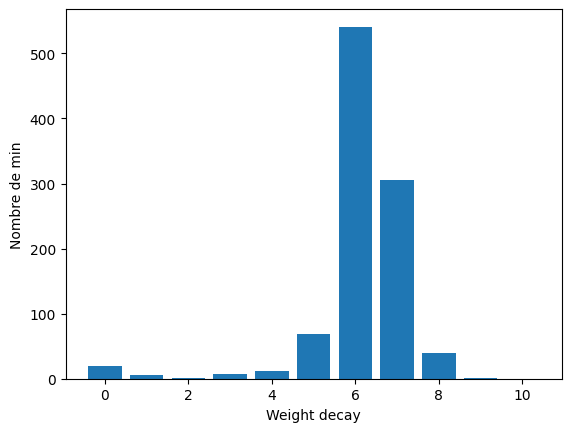

In [79]:
plt.figure()
y=np.zeros(11)
for i in range(1000):
    y[inte[:,i].argmin().item()] += 1
print(y)
plt.bar(np.arange(len(y)),y )
plt.xlabel("Weight decay")
plt.ylabel("Nombre de min")
plt.show()


In [10]:
last_outputs_path=os.path.join(models_folder,"last_outputs_per_wd","val2")
last_outputs = torch.load(f'{last_outputs_path}/last_ouputs_per_wd.pt', map_location='cpu')
last_outputs.shape

torch.Size([11, 50000, 1000])

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [84]:
len(dataset.labels)

NameError: name 'dataset' is not defined

In [40]:
len(last_outputs[0].argmax(dim=1))

50000

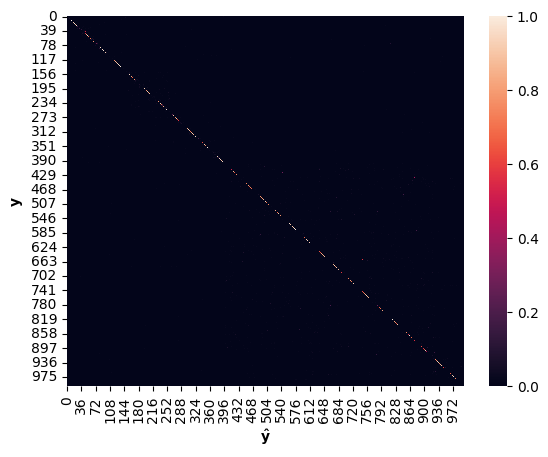

In [41]:
x = 0
y = 1000
cf_matrix = confusion_matrix(dataset.labels, last_outputs[6].argmax(dim=1))
plt.figure()
cf_matrix = cf_matrix[x:y,x:y]
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None])

sn.heatmap(df_cm)
plt.xlabel("$\mathbf{\hat{y}}$")
plt.ylabel("$\mathbf{y}$")
plt.savefig(f"../figures/matrice_de_confusion_[{x}, {y}].png", dpi=500, pil_kwargs={'compression_level': 0}, transparent=True)
plt.show()

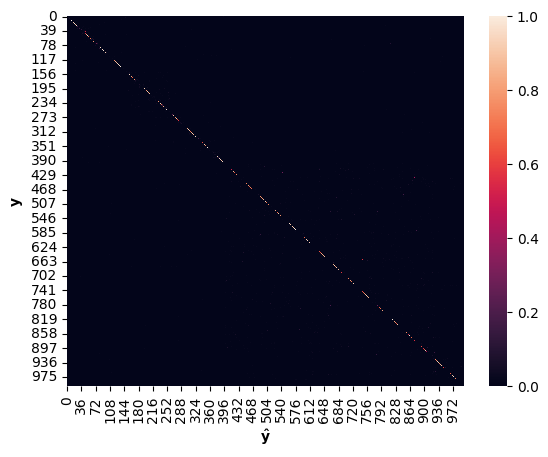

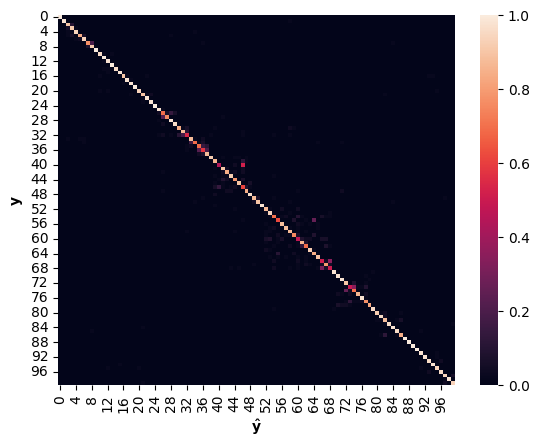

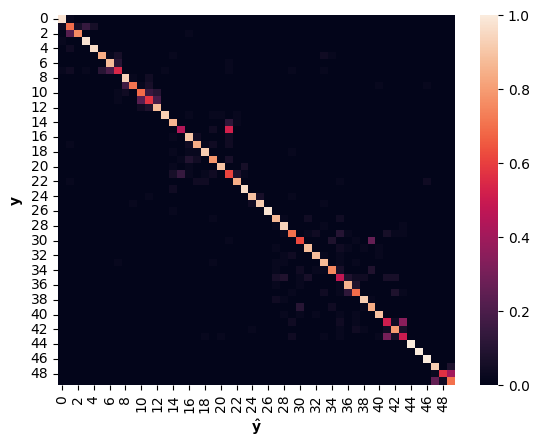

In [12]:
for i in [(0,1000),(0,100),(25, 75)]:
    x = i[0]
    y = i[1]
    cf_matrix = confusion_matrix(dataset.labels, last_outputs[6].argmax(dim=1))
    plt.figure()
    cf_matrix = cf_matrix[x:y,x:y]
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None])
    
    sn.heatmap(df_cm)
    plt.xlabel("$\mathbf{\hat{y}}$")
    plt.ylabel("$\mathbf{y}$")
    plt.savefig(f"../figures/matrice_de_confusion_[{x}, {y}].png",dpi=1000, pil_kwargs={'compression_level': 0})
    plt.show()

IndexError: index 3 is out of bounds for axis 0 with size 3

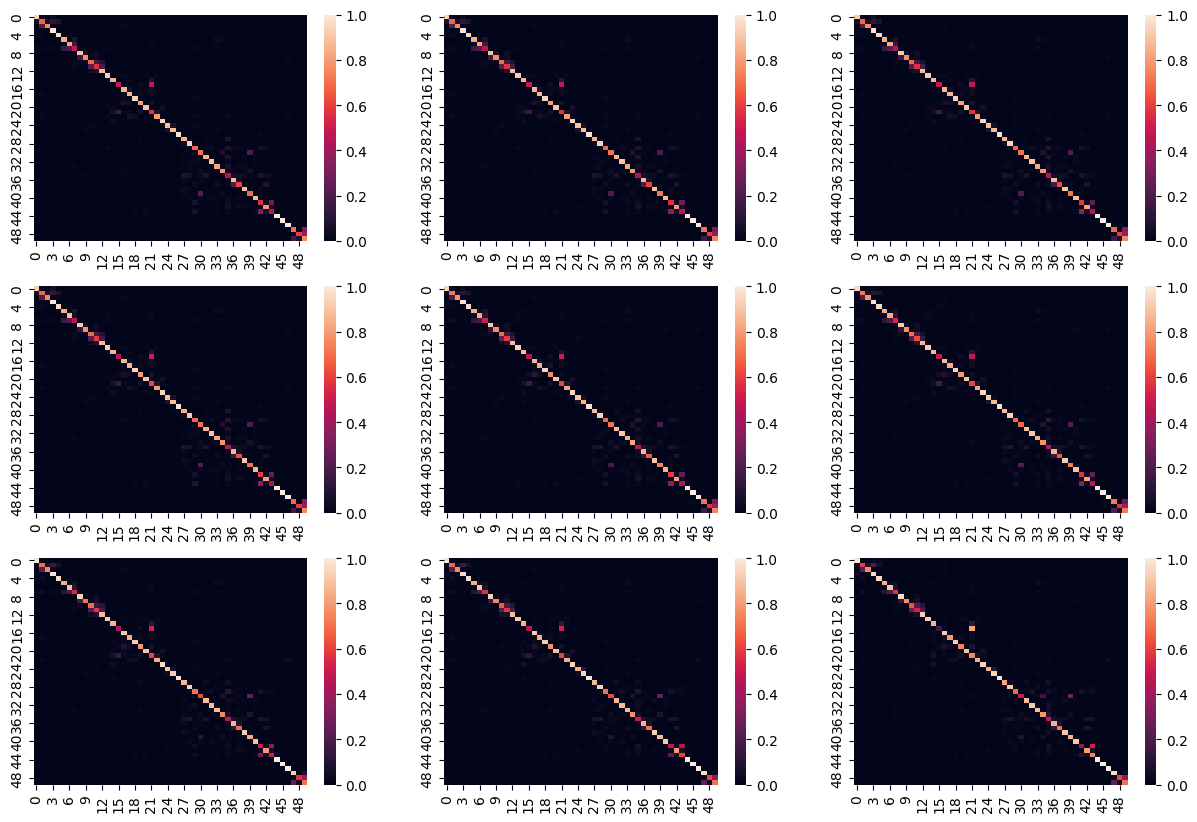

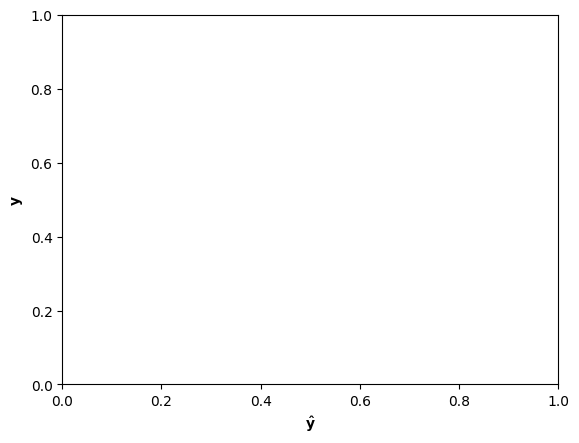

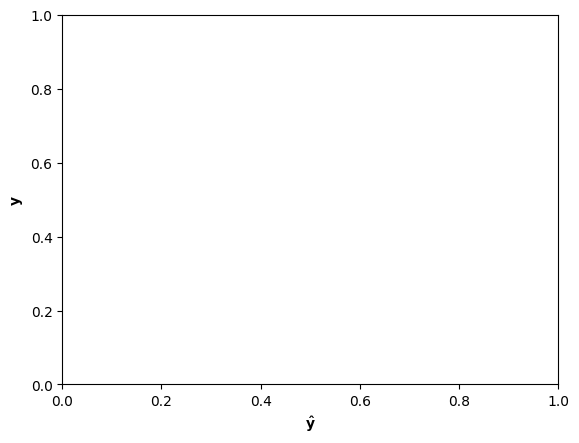

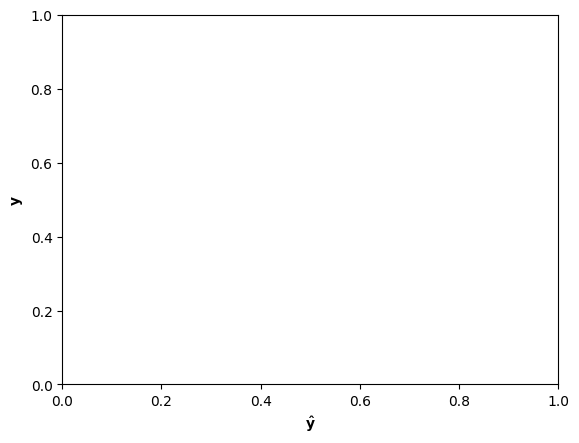

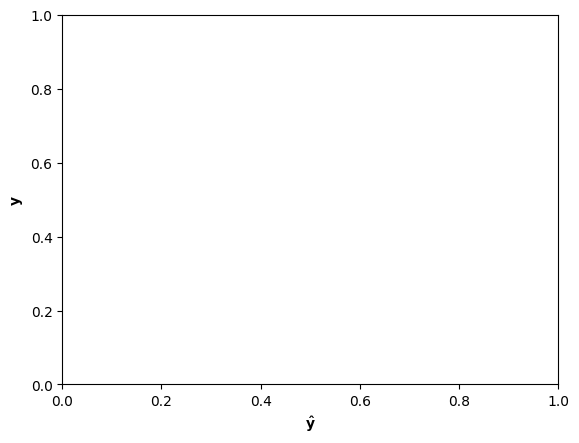

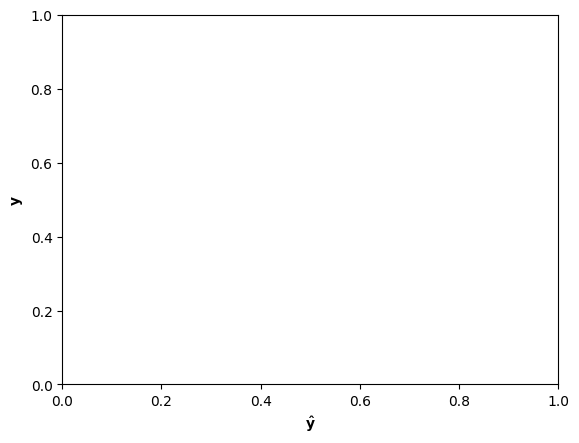

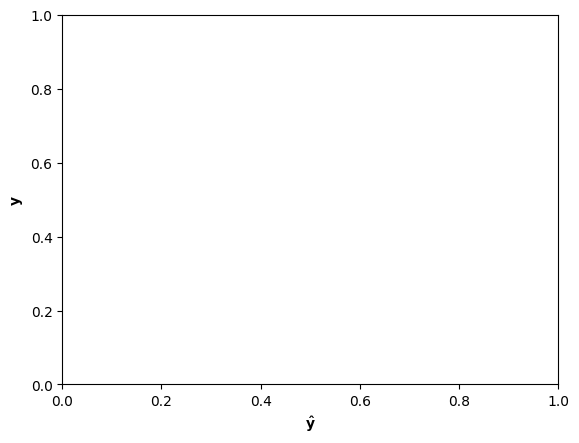

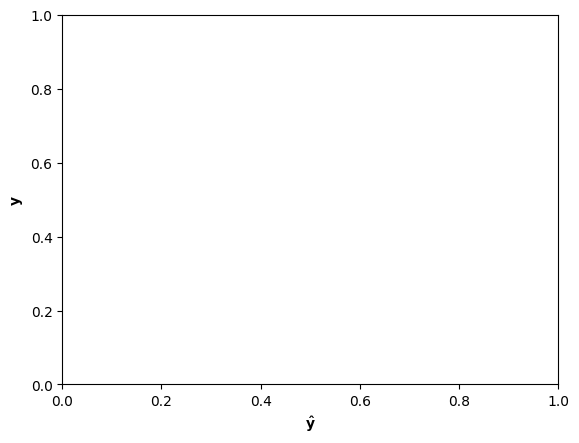

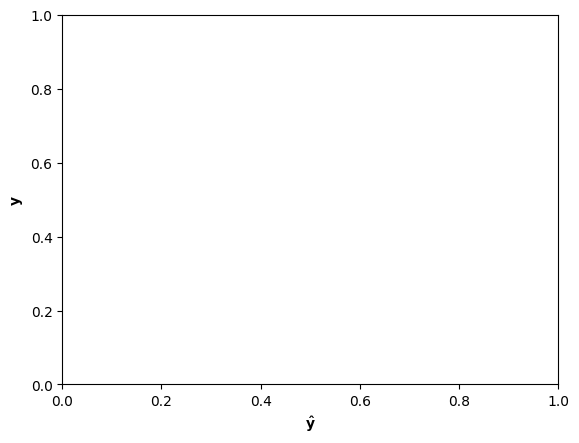

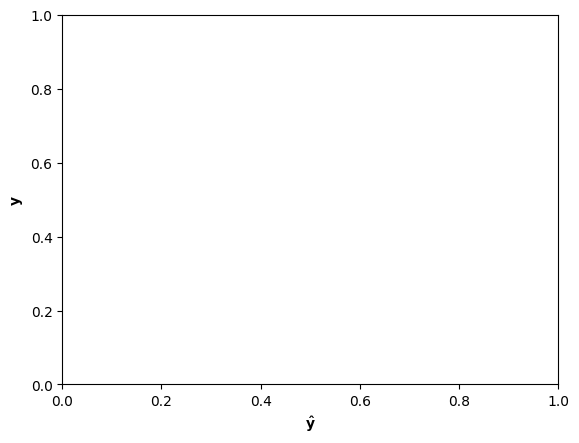

<Figure size 640x480 with 0 Axes>

In [88]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
for i in range(last_outputs.shape[0]):
    x = 25
    y = 75
    cf_matrix = confusion_matrix(dataset.labels, last_outputs[i].argmax(dim=1))
    plt.figure()
    cf_matrix = cf_matrix[x:y,x:y]
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None])
    
    row = i // 3  # Ligne
    col = i % 3   # Colonne

    # Tracer la matrice de confusion sur le sous-graphique
    sn.heatmap(df_cm, ax=axes[row, col])
    plt.xlabel("$\mathbf{\hat{y}}$")
    plt.ylabel("$\mathbf{y}$")
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

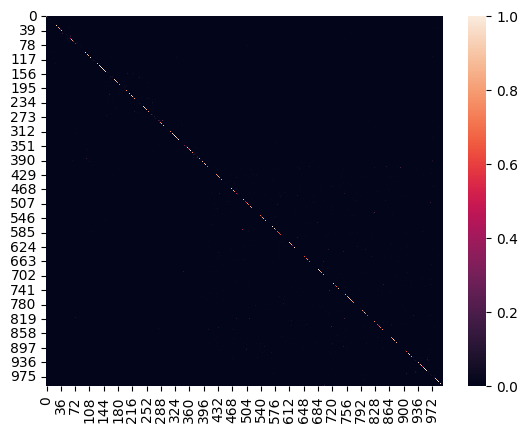

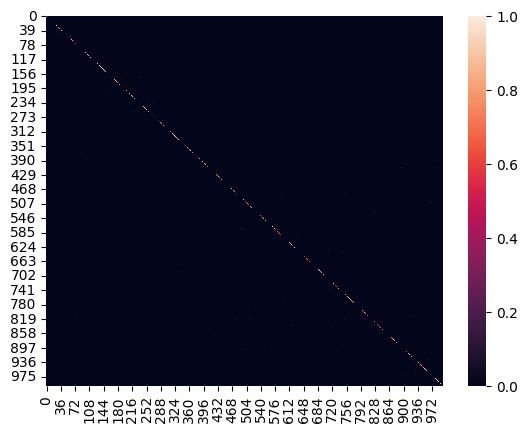

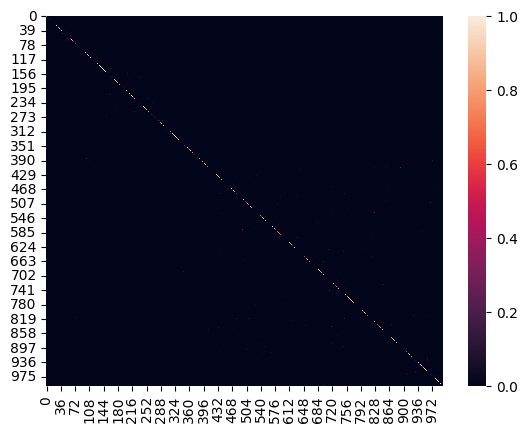

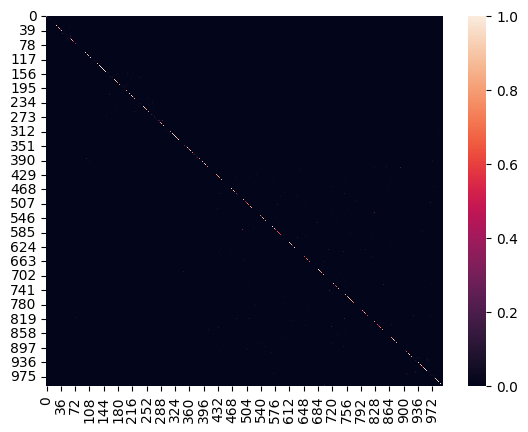

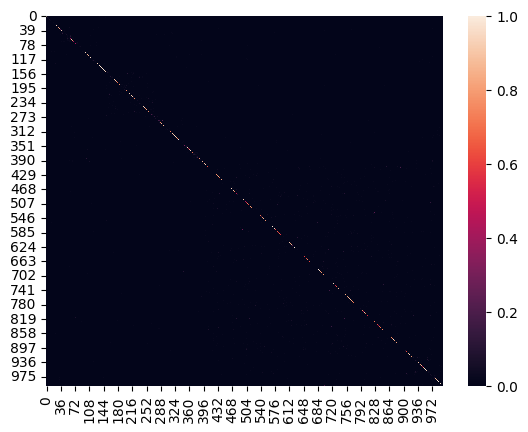

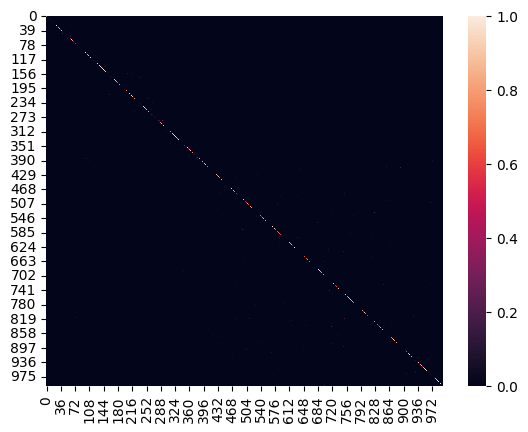

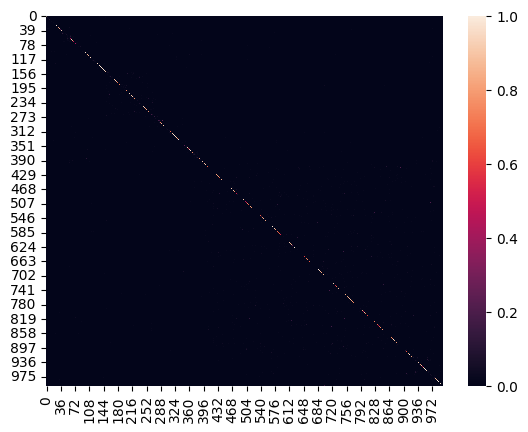

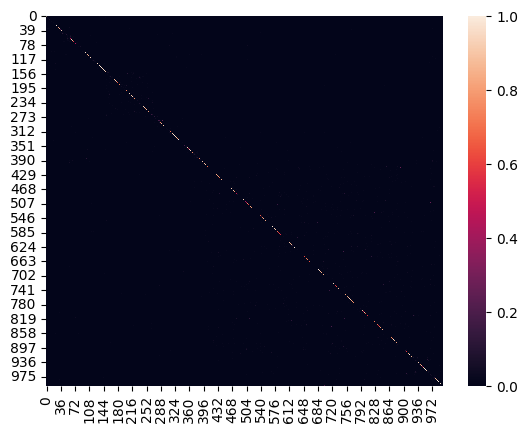

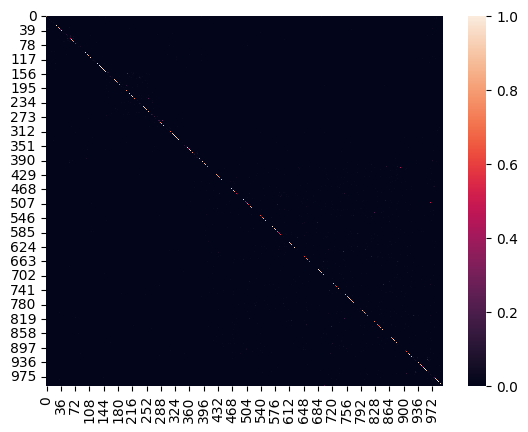

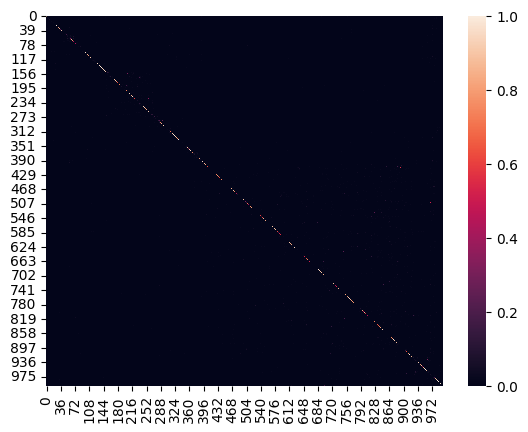

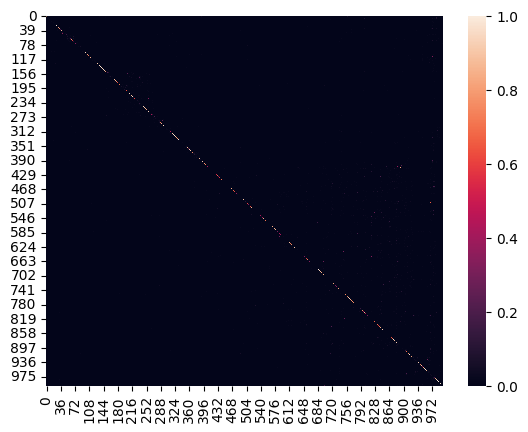

In [42]:
for i in range(last_outputs.shape[0]):
    cf_matrix = confusion_matrix(dataset.labels, last_outputs[i].argmax(dim=1))
    plt.figure()
    cf_matrix = cf_matrix
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None])
    sn.heatmap(df_cm)
    

In [62]:
min_par_classe = []
for c in range(0,1000):#pour chaque classe, on récupère la loss de la dernire epoque atteinte lors de l'epoque sur tous les weight decay différent (i)
    y = []
    x = []
    for i in range(0,9):#pour chaque weight decay
        x.append(i)
        y.append(mean_loss_class[i][89,c])
    min_par_classe.append(torch.argmin(torch.tensor(y)))
min_erreur_classe_wd_0 = []
min_erreur_classe_wd_10_4 = []
min_erreur_classe_wd_3_10_4 = []
min_erreur_classe_wd_10_3 = []
for i,c in enumerate(min_par_classe):
    if c == 0:
        min_erreur_classe_wd_0.append(i)
    elif c == 6:
        min_erreur_classe_wd_10_4.append(i)
    elif c == 7:
        min_erreur_classe_wd_3_10_4.append(i)
    else:
        min_erreur_classe_wd_10_3.append(i)

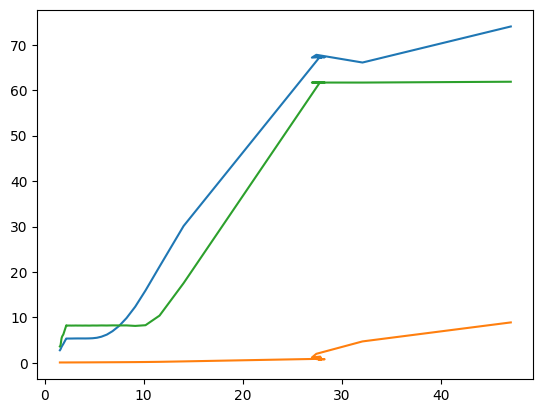

In [67]:
#taux d'erreur par époque sur l'ensemble des classes qui ont leur minimum pour wd 0
taux_erreur_wd_0 = torch.zeros(90)

for i in min_erreur_classe_wd_0:
    taux_erreur_wd_0 += mean_loss_class[0][:,i]
taux_erreur_wd_0 = taux_erreur_wd_0/len(min_erreur_classe_wd_0)

#taux d'erreur par époque sur l'ensemble des classes qui ont leur minimum pour wd 10-4
taux_erreur_wd_10_4 = torch.zeros(90)

for i in min_erreur_classe_wd_10_4:
    taux_erreur_wd_10_4 += mean_loss_class[6][:,i]
taux_erreur_wd_10_4 = taux_erreur_wd_10_4/len(min_erreur_classe_wd_10_4)

#taux d'erreur par époque sur l'ensemble des classes qui ont leur minimum pour wd 10-4
taux_erreur_wd_3_10_4 = torch.zeros(90)

for i in min_erreur_classe_wd_3_10_4:
    taux_erreur_wd_3_10_4 += mean_loss_class[7][:,i]
taux_erreur_wd_3_10_4 = taux_erreur_wd_3_10_4/len(min_erreur_classe_wd_3_10_4)

taux_erreur_wd_10_3 = torch.zeros(90)

for i in min_erreur_classe_wd_10_3:
    taux_erreur_wd_10_3 += mean_loss_class[8][:,i]
taux_erreur_wd_10_3 = taux_erreur_wd_10_3/len(min_erreur_classe_wd_10_3)

plt.plot(taux_erreur_wd_10_4,taux_erreur_wd_3_10_4)
plt.plot(taux_erreur_wd_10_4,taux_erreur_wd_0)
plt.plot(taux_erreur_wd_10_4,taux_erreur_wd_10_3)